In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44925")
client

<Client: 'tcp://127.0.0.1:44925' processes=8 threads=32, memory=125.89 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:41209' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import gsw
import gcm_filters
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
from xhistogram.xarray import histogram as xhist
# import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.ticker as mtick
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

ntheta = 36

In [7]:
# dsb = xr.open_zarr(op.join(savedir,'Snaps_EnsMean_0001419123.zarr')
#                   ).isel(Z=[14,18,24])
iiter = 1419120
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).isel(Z=[14,18,24]).isel(time=0)

nmembs = range(100,148)
for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                            ).isel(time=0,Z=[14,18,24])
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                    % (nmemb)), 
                                            grid_dir=gdir,
                                            prefix=['snap_diagOcn'], delta_t=2e2,
                                            iters=iiter, 
                                           ).isel(time=0,Z=[14,18,24])
                       ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
ds.coords['nmemb'] = ('nmemb',nmembs)

coords = {
    "Y": {"center": "YC", "left": "YG"},
    "X": {"center": "XC", "left": "XG"}
}
grid = Grid(ds, periodic=['X'], coords=coords)
up = (ds.UVEL - dsb.UVEL).where(ds.maskW!=0.)
vp = (ds.VVEL - dsb.VVEL).where(ds.maskS!=0.)
up

<xarray.DataArray 'UVEL' (nmemb: 48, Z: 3, YC: 900, XG: 1000)>
dask.array<where, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 900, 1000), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 2.233e+03 4.438e+03 1.115e+04
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(3, 900, 1000), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(3, 900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 1.022e+03 1.023e+03 1.026e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [8]:
mask = ~ds.maskC.where(ds.maskC!=0.).to_masked_array().mask
maskx = ~ds.maskW.where(ds.maskW!=0.).to_masked_array().mask
masky = ~ds.maskS.where(ds.maskS!=0.).to_masked_array().mask

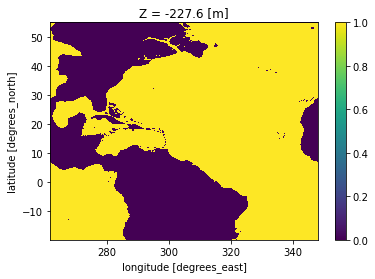

In [9]:
wet_maskx = xr.DataArray(np.zeros((len(ds.Z),len(ds.YC),len(ds.XG))),
                        dims=['Z','YC','XG'],
                        coords={'Z':ds.Z,'YC':ds.YC,'XG':ds.XG
                               }
)
wet_maskx[:,1:-1] = maskx[:,1:-1].astype(np.float64)
wet_masky = xr.DataArray(np.zeros((len(ds.Z),len(ds.YG),len(ds.XC))),
                        dims=['Z','YG','XC'],
                        coords={'Z':ds.Z,'YG':ds.YG,'XC':ds.XC
                               }
)
wet_masky[:,1:-1] = masky[:,1:-1].astype(np.float64)
wet_maskx.isel(Z=0).plot()

In [10]:
areax = ds.dxC * ds.dyG
areay = ds.dxG * ds.dyC
areax

<xarray.DataArray (YC: 900, XG: 1000)>
dask.array<mul, shape=(900, 1000), dtype=float32, chunksize=(900, 1000), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
    dyG      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>

In [11]:
dxw = xr.DataArray(grid.interp(ds.dxG,'Y',boundary='extend').data,
                   dims=areax.dims, coords=areax.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(grid.interp(ds.dyG,'X').data,
                   dims=areax.dims, coords=areax.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(grid.interp(ds.dxC,'Y',boundary='extend').data,
                   dims=areax.dims, coords=areax.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(grid.interp(ds.dyC,'X').data,
                   dims=areax.dims, coords=areax.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'transpose-38b702d58eb24fe31482bd4983959b27' (YC: 900,
                                                                XG: 1000)>
dask.array<transpose, shape=(900, 1000), dtype=>f4, chunksize=(900, 1000), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
    dyG      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>

In [12]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values
dx_min

array(5493.5386, dtype=float32)

In [13]:
kappa_w = xr.ones_like(wet_maskx)
kappa_s = xr.ones_like(wet_maskx)
kappa_s

<xarray.DataArray (Z: 3, YC: 900, XG: 1000)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Coordinates:
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9

In [15]:
filter_scale = 50e3    # 50km
filt_mask = wet_maskx.chunk({'YC':-1,'XG':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YC':-1,'XG':-1}), 'dyw': dyw.chunk({'YC':-1,'XG':-1}), 
            'dxs': dxs.chunk({'YC':-1,'XG':-1}), 'dys': dys.chunk({'YC':-1,'XG':-1}), 
            'area': areax.chunk({'YC':-1,'XG':-1}), 
            'kappa_w': kappa_w.chunk({'YC':-1,'XG':-1}), 
            'kappa_s': kappa_s.chunk({'YC':-1,'XG':-1})
        }
    )
gauss_filter

Filter(filter_scale=50000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [16]:
up_sm5 = gauss_filter.apply(up.chunk({'YC':-1,'XG':-1}), dims=['YC','XG']
                           ).chunk({'YC':100,'XG':100})
up_sm5

<xarray.DataArray (nmemb: 48, Z: 3, YC: 900, XG: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [17]:
filter_scale = 100e3    # 100km
filt_mask = wet_maskx.chunk({'YC':-1,'XG':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YC':-1,'XG':-1}), 'dyw': dyw.chunk({'YC':-1,'XG':-1}), 
            'dxs': dxs.chunk({'YC':-1,'XG':-1}), 'dys': dys.chunk({'YC':-1,'XG':-1}), 
            'area': areax.chunk({'YC':-1,'XG':-1}), 
            'kappa_w': kappa_w.chunk({'YC':-1,'XG':-1}), 
            'kappa_s': kappa_s.chunk({'YC':-1,'XG':-1})
        }
    )
gauss_filter

Filter(filter_scale=100000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=21, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [18]:
up_sm10 = gauss_filter.apply(up.chunk({'YC':-1,'XG':-1}), dims=['YC','XG']
                            ).chunk({'YC':100,'XG':100})
up_sm10

<xarray.DataArray (nmemb: 48, Z: 3, YC: 900, XG: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [19]:
filter_scale = 200e3    # 100km
filt_mask = wet_maskx.chunk({'YC':-1,'XG':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YC':-1,'XG':-1}), 'dyw': dyw.chunk({'YC':-1,'XG':-1}), 
            'dxs': dxs.chunk({'YC':-1,'XG':-1}), 'dys': dys.chunk({'YC':-1,'XG':-1}), 
            'area': areax.chunk({'YC':-1,'XG':-1}), 
            'kappa_w': kappa_w.chunk({'YC':-1,'XG':-1}), 
            'kappa_s': kappa_s.chunk({'YC':-1,'XG':-1})
        }
    )
gauss_filter

Filter(filter_scale=200000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=41, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [20]:
up_sm20 = gauss_filter.apply(up.chunk({'YC':-1,'XG':-1}), dims=['YC','XG']
                            ).chunk({'YC':100,'XG':100})
up_sm20

<xarray.DataArray (nmemb: 48, Z: 3, YC: 900, XG: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [21]:
filter_scale = 250e3    # 250km
filt_mask = wet_maskx.chunk({'YC':-1,'XG':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        n_steps=40,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask.astype(np.float64), 
            'dxw': dxw.astype(np.float64).chunk({'YC':-1,'XG':-1}), 'dyw': dyw.astype(np.float64).chunk({'YC':-1,'XG':-1}), 
            'dxs': dxs.astype(np.float64).chunk({'YC':-1,'XG':-1}), 'dys': dys.astype(np.float64).chunk({'YC':-1,'XG':-1}), 
            'area': areax.astype(np.float64).chunk({'YC':-1,'XG':-1}), 
            'kappa_w': kappa_w.astype(np.float64).chunk({'YC':-1,'XG':-1}), 
            'kappa_s': kappa_s.astype(np.float64).chunk({'YC':-1,'XG':-1})
        }
    )
gauss_filter

<string>:12: UserWarning: You have set n_steps below the default. Results might not be accurate.


Filter(filter_scale=250000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=40, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

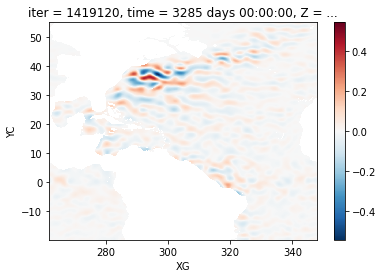

In [22]:
up_sm25 = gauss_filter.apply(up.astype(np.float64).chunk({'YC':-1,'XG':-1}), dims=['YC','XG']
                            ).chunk({'YC':100,'XG':100})
up_sm25.isel(nmemb=0,Z=0).plot()

In [23]:
dxw = xr.DataArray(grid.interp(ds.dxC,'Y',boundary='extend').data,
                   dims=areay.dims, coords=areay.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(grid.interp(ds.dyG,'X').data,
                   dims=areay.dims, coords=areay.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(grid.interp(ds.dxG,'Y',boundary='extend').data,
                   dims=areay.dims, coords=areay.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(grid.interp(ds.dyC,'X').data,
                   dims=areay.dims, coords=areay.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'transpose-80e734f7ce66af18d7f6ae8a147dd887' (YG: 900,
                                                                XC: 1000)>
dask.array<transpose, shape=(900, 1000), dtype=>f4, chunksize=(900, 1000), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    dxG      (YG, XC) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>

In [24]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values
dx_min

array(5493.5386, dtype=float32)

In [25]:
kappa_w = xr.ones_like(wet_masky)
kappa_s = xr.ones_like(wet_masky)
kappa_s

<xarray.DataArray (Z: 3, YG: 900, XC: 1000)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Coordinates:
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0

In [26]:
filter_scale = 50e3    # 50km
filt_mask = wet_masky.chunk({'YG':-1,'XC':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YG':-1,'XC':-1}), 'dyw': dyw.chunk({'YG':-1,'XC':-1}), 
            'dxs': dxs.chunk({'YG':-1,'XC':-1}), 'dys': dys.chunk({'YG':-1,'XC':-1}), 
            'area': areay.chunk({'YG':-1,'XC':-1}), 
            'kappa_w': kappa_w.chunk({'YG':-1,'XC':-1}), 
            'kappa_s': kappa_s.chunk({'YG':-1,'XC':-1})
        }
    )
gauss_filter

Filter(filter_scale=50000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [27]:
vp_sm5 = gauss_filter.apply(vp.chunk({'YG':-1,'XC':-1}), dims=['YG','XC']
                           ).chunk({'YG':100,'XC':100})
vp_sm5

<xarray.DataArray (nmemb: 48, Z: 3, YG: 900, XC: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dxG      (YG, XC) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [28]:
filter_scale = 100e3    # 100km
filt_mask = wet_masky.chunk({'YG':-1,'XC':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YG':-1,'XC':-1}), 'dyw': dyw.chunk({'YG':-1,'XC':-1}), 
            'dxs': dxs.chunk({'YG':-1,'XC':-1}), 'dys': dys.chunk({'YG':-1,'XC':-1}), 
            'area': areay.chunk({'YG':-1,'XC':-1}), 
            'kappa_w': kappa_w.chunk({'YG':-1,'XC':-1}), 
            'kappa_s': kappa_s.chunk({'YG':-1,'XC':-1})
        }
    )
gauss_filter

Filter(filter_scale=100000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=21, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [29]:
vp_sm10 = gauss_filter.apply(vp.chunk({'YG':-1,'XC':-1}), dims=['YG','XC']
                            ).chunk({'YG':100,'XC':100})
vp_sm10

<xarray.DataArray (nmemb: 48, Z: 3, YG: 900, XC: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dxG      (YG, XC) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [30]:
filter_scale = 200e3    # 200km
filt_mask = wet_masky.chunk({'YG':-1,'XC':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YG':-1,'XC':-1}), 'dyw': dyw.chunk({'YG':-1,'XC':-1}), 
            'dxs': dxs.chunk({'YG':-1,'XC':-1}), 'dys': dys.chunk({'YG':-1,'XC':-1}), 
            'area': areay.chunk({'YG':-1,'XC':-1}), 
            'kappa_w': kappa_w.chunk({'YG':-1,'XC':-1}), 
            'kappa_s': kappa_s.chunk({'YG':-1,'XC':-1})
        }
    )
gauss_filter

Filter(filter_scale=200000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=41, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [31]:
vp_sm20 = gauss_filter.apply(vp.chunk({'YG':-1,'XC':-1}), dims=['YG','XC']
                            ).chunk({'YG':100,'XC':100})
vp_sm20

<xarray.DataArray (nmemb: 48, Z: 3, YG: 900, XC: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dxG      (YG, XC) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [32]:
filter_scale = 250e3    # 250km
filt_mask = wet_masky.chunk({'YG':-1,'XC':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        n_steps=40,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask.astype(np.float64), 
            'dxw': dxw.astype(np.float64).chunk({'YG':-1,'XC':-1}), 'dyw': dyw.astype(np.float64).chunk({'YG':-1,'XC':-1}), 
            'dxs': dxs.astype(np.float64).chunk({'YG':-1,'XC':-1}), 'dys': dys.astype(np.float64).chunk({'YG':-1,'XC':-1}), 
            'area': areay.astype(np.float64).chunk({'YG':-1,'XC':-1}), 
            'kappa_w': kappa_w.astype(np.float64).chunk({'YG':-1,'XC':-1}), 
            'kappa_s': kappa_s.astype(np.float64).chunk({'YG':-1,'XC':-1})
        }
    )
gauss_filter

<string>:12: UserWarning: You have set n_steps below the default. Results might not be accurate.


Filter(filter_scale=250000.0, dx_min=array(5493.5386, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=40, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [33]:
vp_sm25 = gauss_filter.apply(vp.chunk({'YG':-1,'XC':-1}), dims=['YG','XC']
                            ).chunk({'YG':100,'XC':100})
vp_sm25

<xarray.DataArray (nmemb: 48, Z: 3, YG: 900, XC: 1000)>
dask.array<rechunk-merge, shape=(48, 3, 900, 1000), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/15)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
    dxG      (YG, XC) >f4 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(3,), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

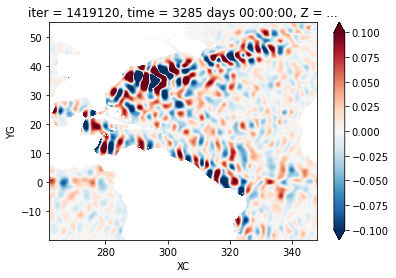

In [34]:
vp_sm25.isel(nmemb=0,Z=0).plot(vmax=.1)

In [31]:
M = .5*(grid.interp(up**2,'X') - grid.interp(vp**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
N = (grid.interp(up,'X') * grid.interp(vp,'Y',boundary='extend')).mean('nmemb',skipna=True)

M5 = .5*(grid.interp(up_sm5**2,'X') - grid.interp(vp_sm5**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
N5 = (grid.interp(up_sm5,'X') * grid.interp(vp_sm5,'Y',boundary='extend')).mean('nmemb',skipna=True)

M10 = .5*(grid.interp(up_sm10**2,'X') - grid.interp(vp_sm10**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
N10 = (grid.interp(up_sm10,'X') * grid.interp(vp_sm10,'Y',boundary='extend')).mean('nmemb',skipna=True)
M10

<xarray.DataArray (Z: 2, YC: 900, XC: 1000)>
dask.array<mul, shape=(2, 900, 1000), dtype=float32, chunksize=(2, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) >f4 -227.6 -1.137e+03

In [35]:
K = .5*(grid.interp(up**2,'X') + grid.interp(vp**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
L = .5*np.sqrt((grid.interp(up**2,'X') - grid.interp(vp**2,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
               + 4*(grid.interp(up,'X') * grid.interp(vp,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
              )

K5 = .5*(grid.interp(up_sm5**2,'X') + grid.interp(vp_sm5**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
L5 = .5*np.sqrt((grid.interp(up_sm5**2,'X') - grid.interp(vp_sm5**2,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
                + 4*(grid.interp(up_sm5,'X') * grid.interp(vp_sm5,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
               )

K10 = .5*(grid.interp(up_sm10**2,'X') + grid.interp(vp_sm10**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
L10 = .5*np.sqrt((grid.interp(up_sm10**2,'X') - grid.interp(vp_sm10**2,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
                 + 4*(grid.interp(up_sm10,'X') * grid.interp(vp_sm10,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
                )
K10

<xarray.DataArray (Z: 3, YC: 900, XC: 1000)>
dask.array<mul, shape=(3, 900, 1000), dtype=float32, chunksize=(3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03

In [36]:
K20 = .5*(grid.interp(up_sm20**2,'X') + grid.interp(vp_sm20**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
L20 = .5*np.sqrt((grid.interp(up_sm20**2,'X') - grid.interp(vp_sm20**2,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
               + 4*(grid.interp(up_sm20,'X') * grid.interp(vp_sm20,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
              )

In [37]:
K25 = .5*(grid.interp(up_sm25**2,'X') + grid.interp(vp_sm25**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
L25 = .5*np.sqrt((grid.interp(up_sm25**2,'X') - grid.interp(vp_sm25**2,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
               + 4*(grid.interp(up_sm25,'X') * grid.interp(vp_sm25,'Y',boundary='extend')).mean('nmemb',skipna=True)**2
              )

In [38]:
theta = .5*np.arctan(2*(grid.interp(up,'X') * grid.interp(vp,'Y',boundary='extend')).mean('nmemb',skipna=True)
                     / (grid.interp(up**2,'X') - grid.interp(vp**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
                    )
theta5 = .5*np.arctan(2*(grid.interp(up_sm5,'X') * grid.interp(vp_sm5,'Y',boundary='extend')).mean('nmemb',skipna=True)
                     / (grid.interp(up_sm5**2,'X') - grid.interp(vp_sm5**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
                    )
theta10 = .5*np.arctan(2*(grid.interp(up_sm10,'X') * grid.interp(vp_sm10,'Y',boundary='extend')).mean('nmemb',skipna=True)
                     / (grid.interp(up_sm10**2,'X') - grid.interp(vp_sm10**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
                    )

In [39]:
theta20 = .5*np.arctan(2*(grid.interp(up_sm20,'X') * grid.interp(vp_sm20,'Y',boundary='extend')).mean('nmemb',skipna=True)
                     / (grid.interp(up_sm20**2,'X') - grid.interp(vp_sm20**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
                    )

In [40]:
theta25 = .5*np.arctan(2*(grid.interp(up_sm25,'X') * grid.interp(vp_sm25,'Y',boundary='extend')).mean('nmemb',skipna=True)
                     / (grid.interp(up_sm25**2,'X') - grid.interp(vp_sm25**2,'Y',boundary='extend')).mean('nmemb',skipna=True)
                    )

In [41]:
dsave = K.to_dataset(name='K')
dsave['L'] = L
dsave['K_50km'] = K5
dsave['L_50km'] = L5
dsave['K_100km'] = K10
dsave['L_100km'] = L10
dsave['K_250km'] = K25
dsave['L_250km'] = L25
dsave['theta'] = theta
dsave['theta_50km'] = theta5
dsave['theta_100km'] = theta10
dsave['theta_250km'] = theta25
dsave = dsave.chunk({'YC':100,'XC':100})
dsave.to_zarr(op.join(savedir,'K-L/1967-01-01.zarr'), mode='w')

In [75]:
dsave = K20.to_dataset(name='K_200km')
dsave['L_200km'] = L20
dsave['theta_200km'] = theta20
dsave = dsave.chunk({'YC':100,'XC':100})
dsave.to_zarr(op.join(savedir,'K-L/200km/1967-01-01.zarr'), mode='w')

In [95]:
dsave = K25.to_dataset(name='K_250km')
dsave['L_250km'] = L25
dsave['theta_250km'] = theta25
dsave = dsave.chunk({'YC':100,'XC':100})
dsave.to_zarr(op.join(savedir,'K-L/250km/1967-01-01.zarr'), mode='w')

In [14]:
dskl = xr.open_zarr(op.join(savedir,'K-L/1967-01-01.zarr'))
# dskl25 = xr.open_zarr(op.join(savedir,'K-L/250km/1967-01-01.zarr'))
dskl

<xarray.Dataset>
Dimensions:      (Z: 3, YC: 900, XC: 1000)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.83 54.92 55.0
  * Z            (Z) float32 -227.6 -452.4 -1.137e+03
Data variables:
    K            (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    K_100km      (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    K_250km      (Z, YC, XC) float64 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    K_50km       (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    L            (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    L_100km      (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    L_250km      (Z, YC, XC) float64 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    L_50km       (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    theta        (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    theta_100km  (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    theta_250km  (Z, YC, XC) float64 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    theta_50km   (Z, YC, XC) float32 dask.array<chunksize=(3, 100, 100), meta=np.ndarray>

In [15]:
a = np.sqrt(dskl.K + dskl.L)
b = np.sqrt(dskl.K - dskl.L)

a5 = np.sqrt(dskl.K_50km + dskl.L_50km)
b5 = np.sqrt(dskl.K_50km - dskl.L_50km)

a10 = np.sqrt(dskl.K_100km + dskl.L_100km)
b10 = np.sqrt(dskl.K_100km - dskl.L_100km)

a25 = np.sqrt(dskl.K_250km + dskl.L_250km)
b25 = np.sqrt(dskl.K_250km - dskl.L_250km)
a10

<xarray.DataArray (Z: 3, YC: 900, XC: 1000)>
dask.array<sqrt, shape=(3, 900, 1000), dtype=float32, chunksize=(3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -227.6 -452.4 -1.137e+03

In [16]:
ratio = a/b
ratio5 = a5/b5
ratio10 = a10/b10
ratio25 = a25/b25
ratio25

<xarray.DataArray (Z: 3, YC: 900, XC: 1000)>
dask.array<truediv, shape=(3, 900, 1000), dtype=float64, chunksize=(3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -227.6 -452.4 -1.137e+03

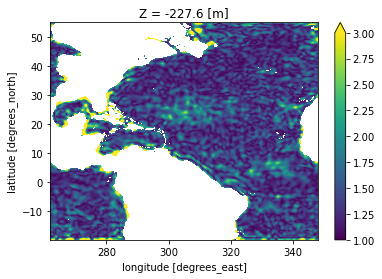

In [99]:
ratio25.isel(Z=0).plot(vmax=3)

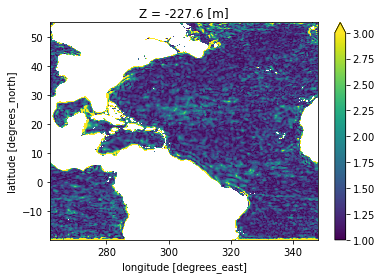

In [71]:
ratio5.isel(Z=0).plot(vmax=3)

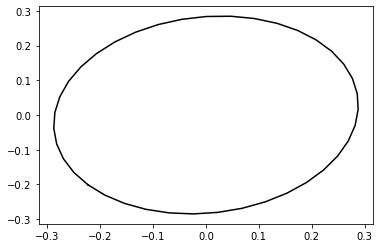

In [43]:
angles = np.linspace(-np.pi,np.pi,40)
rotation = np.matrix([[np.cos(dskl.theta_100km.isel(Z=0).sel(XC=300, method='nearest').sel(YC=35, method='nearest')), 
                       -np.sin(dskl.theta_100km.isel(Z=0).sel(XC=300, method='nearest').sel(YC=35, method='nearest'))], 
                      [np.sin(dskl.theta_100km.isel(Z=0).sel(XC=300, method='nearest').sel(YC=35, method='nearest')),  
                       np.cos(dskl.theta_100km.isel(Z=0).sel(XC=300, method='nearest').sel(YC=35, method='nearest'))]]
                    )
axes = np.array([a10.isel(Z=0).sel(XC=300, method='nearest').sel(YC=35, method='nearest').values*np.cos(angles),
                 b10.isel(Z=0).sel(XC=300, method='nearest').sel(YC=35, method='nearest').values*np.sin(angles)]
               )
# np.dot(rotation, axes).shape

fig, ax = plt.subplots()
ax.plot(np.squeeze(np.asarray(np.dot(rotation, axes)[0])), np.squeeze(np.asarray(np.dot(rotation, axes)[1])),
        'k'
       )

In [28]:
angles = np.linspace(-np.pi,np.pi,40)
dg = 32
xx = xr.DataArray(np.ones((2, len(angles),
                           len(b.YC[dg//2:][::dg]),
                           len(a.XC[dg//2:][::dg]))),
                  dims=['ab','angle','YC','XC'],
                  coords={'angle':angles,'YC':b.YC[dg//2:][::dg],
                          'XC':a.XC[dg//2:][::dg]}
                 ) * np.nan
xx5 = xx.copy()
xx10 = xx.copy()
xx25 = xx.copy()


for i in a.XC[dg//2:][::dg]:
    for j in b.YC[dg//2:][::dg]:
        
        rotation = np.matrix([
                      [ np.cos(dskl.theta.isel(Z=0).sel(XC=i, YC=j)), 
                       -np.sin(dskl.theta.isel(Z=0).sel(XC=i, YC=j))], 
                      [ np.sin(dskl.theta.isel(Z=0).sel(XC=i, YC=j)),  
                        np.cos(dskl.theta.isel(Z=0).sel(XC=i, YC=j))]]
                   )
        axes = np.array([a.isel(Z=0).sel(XC=i, YC=j).values*np.cos(angles),
                         b.isel(Z=0).sel(XC=i, YC=j).values*np.sin(angles)]
               )
        xx.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
        
        rotation = np.matrix([
                      [ np.cos(dskl.theta_50km.isel(Z=0).sel(XC=i, YC=j)), 
                       -np.sin(dskl.theta_50km.isel(Z=0).sel(XC=i, YC=j))], 
                      [ np.sin(dskl.theta_50km.isel(Z=0).sel(XC=i, YC=j)),  
                        np.cos(dskl.theta_50km.isel(Z=0).sel(XC=i, YC=j))]]
                   )
        axes = np.array([a5.isel(Z=0).sel(XC=i, YC=j).values*np.cos(angles),
                         b5.isel(Z=0).sel(XC=i, YC=j).values*np.sin(angles)]
               )
        xx5.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
        
        rotation = np.matrix([
                      [ np.cos(dskl.theta_100km.isel(Z=0).sel(XC=i, YC=j)), 
                       -np.sin(dskl.theta_100km.isel(Z=0).sel(XC=i, YC=j))], 
                      [ np.sin(dskl.theta_100km.isel(Z=0).sel(XC=i, YC=j)),  
                        np.cos(dskl.theta_100km.isel(Z=0).sel(XC=i, YC=j))]]
                   )
        axes = np.array([a10.isel(Z=0).sel(XC=i, YC=j).values*np.cos(angles),
                         b10.isel(Z=0).sel(XC=i, YC=j).values*np.sin(angles)]
               )
        xx10.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
        
        # rotation = np.matrix([
        #               [ np.cos(dskl20.theta_200km.isel(Z=0).sel(XC=i, YC=j)), 
        #                -np.sin(dskl20.theta_200km.isel(Z=0).sel(XC=i, YC=j))], 
        #               [ np.sin(dskl20.theta_200km.isel(Z=0).sel(XC=i, YC=j)),  
        #                 np.cos(dskl20.theta_200km.isel(Z=0).sel(XC=i, YC=j))]]
        #            )
        # axes = np.array([a20.isel(Z=0).sel(XC=i, YC=j).values*np.cos(angles),
        #                  b20.isel(Z=0).sel(XC=i, YC=j).values*np.sin(angles)]
        #        )
        # xx20.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
        rotation = np.matrix([
                      [ np.cos(dskl.theta_250km.isel(Z=0).sel(XC=i, YC=j)), 
                       -np.sin(dskl.theta_250km.isel(Z=0).sel(XC=i, YC=j))], 
                      [ np.sin(dskl.theta_250km.isel(Z=0).sel(XC=i, YC=j)),  
                        np.cos(dskl.theta_250km.isel(Z=0).sel(XC=i, YC=j))]]
                   )
        axes = np.array([a25.isel(Z=0).sel(XC=i, YC=j).values*np.cos(angles),
                         b25.isel(Z=0).sel(XC=i, YC=j).values*np.sin(angles)]
               )
        xx25.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))

Task exception was never retrieved
future: <Task finished name='Task-37099' coro=<Client._gather.<locals>.wait() done, defined at /tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/distributed/client.py:2007> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/distributed/client.py", line 2016, in wait
    raise AllExit()
distributed.client.AllExit


In [29]:
dsave = xx.to_dataset(name='axes')
dsave['axes_50km'] = xx5
dsave['axes_100km'] = xx10
dsave['axes_250km'] = xx25
dsave.to_zarr(op.join(savedir,'Ellipes/1967-01-01.zarr'), mode='w')

In [100]:
angles = np.linspace(-np.pi,np.pi,40)
dg = 32
xx25 = xr.DataArray(np.ones((2, len(angles),
                            len(b.YC[dg//2:][::dg]),
                            len(a.XC[dg//2:][::dg]))),
                    dims=['ab','angle','YC','XC'],
                    coords={'angle':angles,'YC':b.YC[dg//2:][::dg],
                            'XC':a.XC[dg//2:][::dg]}
                   ) * np.nan


for i in a.XC[dg//2:][::dg]:
    for j in b.YC[dg//2:][::dg]:
        
        rotation = np.matrix([
                      [ np.cos(dskl25.theta_250km.isel(Z=0).sel(XC=i, YC=j)), 
                       -np.sin(dskl25.theta_250km.isel(Z=0).sel(XC=i, YC=j))], 
                      [ np.sin(dskl25.theta_250km.isel(Z=0).sel(XC=i, YC=j)),  
                        np.cos(dskl25.theta_250km.isel(Z=0).sel(XC=i, YC=j))]]
                   )
        axes = np.array([a25.isel(Z=0).sel(XC=i, YC=j).values*np.cos(angles),
                         b25.isel(Z=0).sel(XC=i, YC=j).values*np.sin(angles)]
               )
        xx25.sel(XC=i,YC=j)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))

In [101]:
dsave = xx25.to_dataset(name='axes_250km')
dsave.to_zarr(op.join(savedir,'Ellipes/250km/1967-01-01.zarr'), mode='w')

In [18]:
dsax = xr.open_zarr(op.join(savedir,'Ellipses/1967-01-01.zarr'))
dsax25 = xr.open_zarr(op.join(savedir,'Ellipses/250km/1967-01-01.zarr'))
dsax

<xarray.Dataset>
Dimensions:     (XC: 31, YC: 28, angle: 40, ab: 2)
Coordinates:
  * XC          (XC) float32 263.4 266.1 268.9 271.6 ... 337.7 340.5 343.2 346.0
  * YC          (YC) float32 -18.58 -15.92 -13.25 -10.58 ... 48.08 50.75 53.42
  * angle       (angle) float64 -3.142 -2.98 -2.819 -2.658 ... 2.819 2.98 3.142
Dimensions without coordinates: ab
Data variables:
    axes        (ab, angle, YC, XC) float64 dask.array<chunksize=(1, 40, 28, 31), meta=np.ndarray>
    axes_100km  (ab, angle, YC, XC) float64 dask.array<chunksize=(1, 40, 28, 31), meta=np.ndarray>
    axes_200km  (ab, angle, YC, XC) float64 dask.array<chunksize=(1, 40, 28, 31), meta=np.ndarray>
    axes_50km   (ab, angle, YC, XC) float64 dask.array<chunksize=(1, 40, 28, 31), meta=np.ndarray>

In [17]:
angles = np.linspace(-np.pi,np.pi,40)
dg = 32
xx = xr.DataArray(np.ones((2, len(angles), len(xs))),
                  dims=['ab','angle','reg'],
                  coords={'angle':angles,'reg':range(6)}
                 ) * np.nan
xx5 = xx.copy()
xx10 = xx.copy()
# xx20 = xx.copy()
xx25 = xx.copy()


for i in range(len(xs)):
    # rotation = np.matrix([
    #                   [ np.cos(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')), 
    #                    -np.sin(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))], 
    #                   [ np.sin(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')),  
    #                     np.cos(dskl.theta.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))]]
    #                )
    axes = np.array([a.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.cos(angles),
                     b.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.sin(angles)]
               )
    # xx.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
    xx.isel(reg=i)[:] = axes
        
#     # rotation = np.matrix([
#     #                   [ np.cos(dskl.theta_50km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')), 
#     #                    -np.sin(dskl.theta_50km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))], 
#     #                   [ np.sin(dskl.theta_50km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')),  
#     #                     np.cos(dskl.theta_50km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))]]
#     #                )
#     axes = np.array([a5.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').isel().values*np.cos(angles),
#                      b5.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.sin(angles)]
#                )
#     # xx5.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
#     xx5.isel(reg=i)[:] = axes
        
#     # rotation = np.matrix([
#     #                   [ np.cos(dskl.theta_100km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')), 
#     #                    -np.sin(dskl.theta_100km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))], 
#     #                   [ np.sin(dskl.theta_100km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')),  
#     #                     np.cos(dskl.theta_100km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))]]
#     #                )
#     axes = np.array([a10.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.cos(angles),
#                      b10.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.sin(angles)]
#                )
#     # xx10.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
#     xx10.isel(reg=i)[:] = axes
        
#     # rotation = np.matrix([
#     #                   [ np.cos(dskl20.theta_200km.isel(Z=0,XC=xs[i],YC=ys[i])), 
#     #                    -np.sin(dskl20.theta_200km.isel(Z=0,XC=xs[i],YC=ys[i]))], 
#     #                   [ np.sin(dskl20.theta_200km.isel(Z=0,XC=xs[i],YC=ys[i])),  
#     #                     np.cos(dskl20.theta_200km.isel(Z=0,XC=xs[i],YC=ys[i]))]]
#     #                )
#     # axes = np.array([a20.isel(Z=0,XC=xs[i],YC=ys[i]).values*np.cos(angles),
#     #                      b20.isel(Z=0,XC=xs[i],YC=ys[i]).values*np.sin(angles)]
#     #            )
#     # xx20.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
    
    # rotation = np.matrix([
    #                   [ np.cos(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')), 
    #                    -np.sin(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))], 
    #                   [ np.sin(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest')),  
    #                     np.cos(dskl25.theta_250km.isel(Z=0).sel(XC=xs[i],YC=ys[i],method='nearest'))]]
    #                )
    axes = np.array([a25.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.cos(angles),
                     b25.isel(Z=1).sel(XC=xs[i],YC=ys[i],method='nearest').values*np.sin(angles)]
               )
    # xx25.isel(reg=i)[:] = np.squeeze(np.asarray(np.dot(rotation, axes)))
    xx25.isel(reg=i)[:] = axes

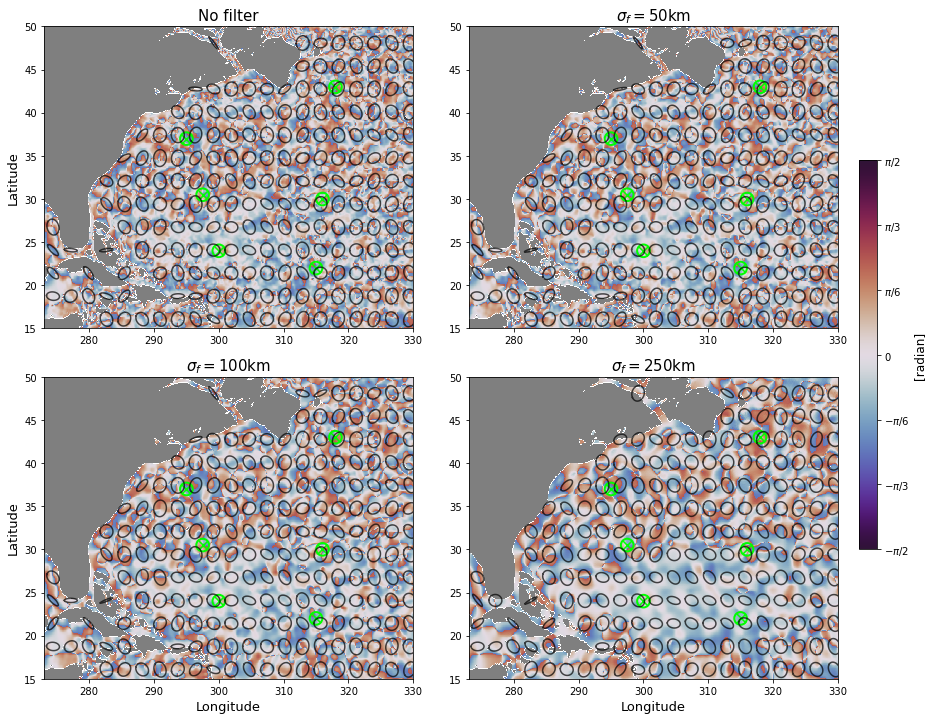

In [103]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(dsb.XC, dsb.YC, dskl.theta.isel(Z=0),
                          rasterized=True, vmax=np.pi/2, vmin=-np.pi/2, cmap='twilight_shifted')
axes[0,1].pcolormesh(dsb.XC, dsb.YC, dskl.theta_50km.isel(Z=0),
                     rasterized=True, vmax=np.pi/2, vmin=-np.pi/2, cmap='twilight_shifted')
axes[1,0].pcolormesh(dsb.XC, dsb.YC, dskl.theta_100km.isel(Z=0),
                     rasterized=True, vmax=np.pi/2, vmin=-np.pi/2, cmap='twilight_shifted')
axes[1,1].pcolormesh(dsb.XC, dsb.YC, dskl25.theta_250km.isel(Z=0),
                     rasterized=True, vmax=np.pi/2, vmin=-np.pi/2, cmap='twilight_shifted')

axes[0,0].pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0.).isel(Z=0), 
                     vmin=-2, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0.).isel(Z=0), 
                     vmin=-2, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0.).isel(Z=0), 
                     vmin=-2, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(ds.XC, ds.YC, ds.maskC.where(ds.maskC==0.).isel(Z=0), 
                     vmin=-2, vmax=2, cmap='binary', rasterized=True)

re = 1e0
for i in dsax.XC.sel(XC=slice(273,330)):
    for j in dsax.YC.sel(YC=slice(15,50)):
        # if j < 45:
            # area = np.pi*a.isel(Z=0).sel(XC=i, YC=j)*b.isel(Z=0).sel(XC=i, YC=j)
        axes[0,0].plot(dsax.axes.sel(XC=i, YC=j)[0]/a.isel(Z=0).sel(XC=i, YC=j)*re+i, 
                       dsax.axes.sel(XC=i, YC=j)[1]/a.isel(Z=0).sel(XC=i, YC=j)*re+j, 
                       'k', alpha=.7)
            # area = np.pi*a5.isel(Z=0).sel(XC=i, YC=j)*b5.isel(Z=0).sel(XC=i, YC=j)
        axes[0,1].plot(dsax.axes_50km.sel(XC=i, YC=j)[0]/a5.isel(Z=0).sel(XC=i, YC=j)*re+i, 
                       dsax.axes_50km.sel(XC=i, YC=j)[1]/a5.isel(Z=0).sel(XC=i, YC=j)*re+j, 
                       'k', alpha=.7)
            # area = np.pi*a10.isel(Z=0).sel(XC=i, YC=j)*b10.isel(Z=0).sel(XC=i, YC=j)
        axes[1,0].plot(dsax.axes_100km.sel(XC=i, YC=j)[0]/a10.isel(Z=0).sel(XC=i, YC=j)*re+i, 
                       dsax.axes_100km.sel(XC=i, YC=j)[1]/a10.isel(Z=0).sel(XC=i, YC=j)*re+j, 
                       'k', alpha=.7)
            # area = np.pi*a20.isel(Z=0).sel(XC=i, YC=j)*b20.isel(Z=0).sel(XC=i, YC=j)
        axes[1,1].plot(dsax25.axes_250km.sel(XC=i, YC=j)[0]/a25.isel(Z=0).sel(XC=i, YC=j)*re+i, 
                       dsax25.axes_250km.sel(XC=i, YC=j)[1]/a25.isel(Z=0).sel(XC=i, YC=j)*re+j, 
                       'k', alpha=.7)
        
axes[0,0].set_ylim([15,50])
axes[0,0].set_xlim([273,330])
axes[0,1].set_ylim([15,50])
axes[0,1].set_xlim([273,330])
axes[1,0].set_ylim([15,50])
axes[1,0].set_xlim([273,330])
axes[1,1].set_ylim([15,50])
axes[1,1].set_xlim([273,330])

axes[0,0].scatter(xs, ys, marker='x', s=80, c='lime')
axes[0,0].scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)
axes[0,1].scatter(xs, ys, marker='x', s=80, c='lime')
axes[0,1].scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)
axes[1,0].scatter(xs, ys, marker='x', s=80, c='lime')
axes[1,0].scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)
axes[1,1].scatter(xs, ys, marker='x', s=80, c='lime')
axes[1,1].scatter(xs, ys, marker='o', s=160, facecolors='none', edgecolors='lime', linewidths=2)

axes[0,0].set_title(r"No filter", fontsize=15)
axes[0,1].set_title(r"$\sigma_f = 50$km", fontsize=15)
axes[1,0].set_title(r"$\sigma_f = 100$km", fontsize=15)
axes[1,1].set_title(r"$\sigma_f = 250$km", fontsize=15)

fig.subplots_adjust(right=0.86, hspace=.16, wspace=.15) 
cbax = fig.add_axes([0.88, 0.275, 0.016, 0.45])
cbar = fig.colorbar(im, cax=cbax, orientation='vertical',  
                    ticks=[-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
                   )
cbar.ax.set_yticklabels([
    r"$-\pi/2$",r"$-\pi/3$",r"$-\pi/6$",r"$0$",r"$\pi/6$",r"$\pi/3$",r"$\pi/2$"
])
cbar.set_label(r"[radian]", fontsize=12)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)

plt.savefig(op.join(savedir,'Figs/Anisotropy_filtered-250km.pdf'))

In [18]:
reg = 0
ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
# ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
# MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
#         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
#        )
MtE = (ds4.iso_uA + ds4.iso_vA)
dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                   coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                  ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
Ak = (ds0.iso_uA + ds1.iso_vA
      # - (ds4.iso_uA + ds4.iso_vA)
      - MtE
     )
Fmte = (MtE * dks).cumsum('scale').compute()
piw = ((Ak) * dks).cumsum('scale').compute()
piw

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (nmemb: 48, Z: 3, angle: 18, scale: 40)>
array([[[[-5.12191072e-13, -9.45249045e-13, -8.84848007e-12, ...,
          -1.15570896e-07, -1.17399277e-07, -1.18949295e-07],
         [ 7.39003007e-13,  3.48611811e-12, -3.51293266e-11, ...,
          -9.04859927e-08, -8.98026630e-08, -8.90191562e-08],
         [ 8.53540821e-13,  9.24319548e-12,  7.91148494e-12, ...,
          -1.84780055e-08, -1.42169811e-08, -1.02472827e-08],
         ...,
         [ 1.46624674e-11,  6.10561526e-10,  2.71871476e-09, ...,
           2.06876966e-07,  2.05114166e-07,  2.03304934e-07],
         [ 6.00991742e-12,  1.45302527e-10,  5.15483561e-10, ...,
           9.11545065e-08,  8.86144527e-08,  8.61900665e-08],
         [ 1.81786729e-13,  2.26504307e-11, -1.98212500e-11, ...,
          -6.10879544e-08, -6.38596407e-08, -6.63702630e-08]],

        [[-1.89862923e-14, -3.17059998e-13,  6.73702553e-13, ...,
          -1.54842864e-08, -1.60151575e-08, -1.64899938e-08],
         [ 1.99521915e-14,  1.99065794e-13,  1.92480788e-12, ...,
          -2.16825254e-08, -2.14522205e-08, -2.12168230e-08],
         [ 3.37572520e-14,  5.03935624e-13, -2.04241756e-12, ...,
          -2.62357393e-09, -1.20183996e-09,  1.05462664e-10],
...
         [ 9.53465413e-14,  1.85070121e-12,  3.24466276e-12, ...,
           6.78228063e-09,  6.51117500e-09,  6.27884528e-09],
         [-4.01700145e-14, -7.27785161e-13,  1.19600048e-12, ...,
           4.45674255e-09,  4.23089322e-09,  4.03292262e-09],
         [-7.57081587e-14, -3.42831191e-13,  2.15030676e-12, ...,
          -2.62000839e-09, -2.66731212e-09, -2.70834433e-09]],

        [[-2.45664894e-15,  5.83365171e-15, -1.04548712e-13, ...,
          -1.48909114e-09, -1.52373061e-09, -1.55500831e-09],
         [-4.59022537e-16, -3.17701519e-14, -6.58679913e-13, ...,
           7.73228900e-10,  7.19683436e-10,  6.72539094e-10],
         [ 1.55209822e-15, -3.16854159e-14,  3.24828840e-13, ...,
           3.78322287e-09,  3.76808193e-09,  3.75403366e-09],
         ...,
         [ 1.00608082e-15,  1.12574851e-13,  7.89520924e-13, ...,
          -5.11549291e-10, -5.36256049e-10, -5.58914242e-10],
         [ 1.01225180e-15,  6.62163276e-14,  6.18999795e-13, ...,
          -5.77507644e-10, -5.99025875e-10, -6.17680580e-10],
         [ 1.00763737e-15,  2.06944031e-14,  3.37151395e-13, ...,
          -1.80347290e-09, -1.81977302e-09, -1.83432509e-09]]]])
Coordinates:
  * Z        (Z) float32 -227.6 -452.4 -1.137e+03
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 1.983e+04 3.118e+04 ... 4.511e+05 4.624e+05

In [19]:
# phi = np.linspace(-np.pi,np.pi,40)
# r = np.sqrt(xx[0]**2 + xx[1]**2)
# r25 = np.sqrt(xx25[0]**2 + xx25[1]**2)
r = a*b / np.sqrt((b*xr.DataArray(np.cos(angles),dims='angle',coords={'angle':angles}))**2 
                  + (a*xr.DataArray(np.sin(angles),dims='angle',coords={'angle':angles}))**2)
r25 = a25*b25 / np.sqrt((b25*xr.DataArray(np.cos(angles),dims='angle',coords={'angle':angles}))**2 
                        + (a25*xr.DataArray(np.sin(angles),dims='angle',coords={'angle':angles}))**2)
r

,Array,Chunk
Bytes,823.97 MiB,9.16 MiB
Shape,"(3, 900, 1000, 40)","(3, 100, 100, 40)"
Count,1804 Tasks,90 Chunks
Type,float64,numpy.ndarray


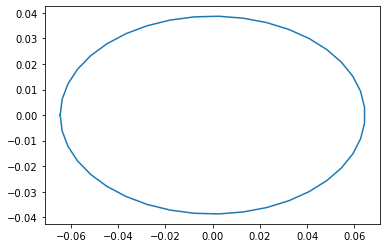

In [29]:
plt.plot(xx.isel(reg=reg)[0],xx.isel(reg=reg)[1])

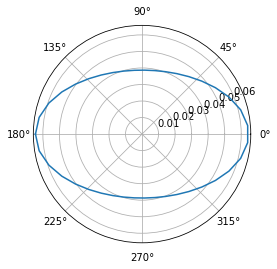

In [33]:
ax = plt.subplot(111, projection='polar')
ax.plot(angles, r.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest'))

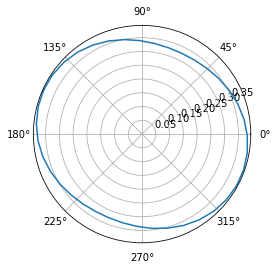

In [69]:
ax = plt.subplot(111, projection='polar')
ax.plot(angles+dskl.theta.isel(Z=0).sel(XC=xs[0],YC=ys[0],method='nearest').values, r)

In [20]:
values = np.array([8,3,2.,.1,.06,.06])

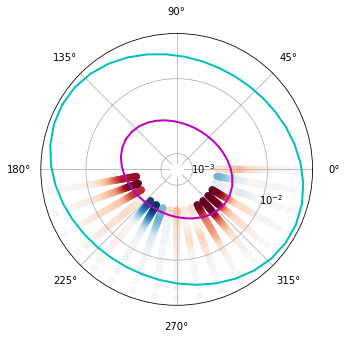

In [21]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    # # There should be a method for this, but there isn't... Pull request?
    # ax2._r_label_position._t = (22.5 + 180, 0.0)
    # ax2._r_label_position.invalidate()
    # # Ensure that original axes tick labels are on top of plots in twinned axes
    # for label in ax.get_yticklabels():
    #     ax.figure.texts.append(label)
    return ax2


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='polar')
ax2 = polar_twin(ax)
for i in range(len(piw.angle)):
    # y = piw.scale**-1*1e3 * np.sin(piw.angle.isel(angle=i))
    # x = piw.scale**-1*1e3 * np.cos(piw.angle.isel(angle=i))
    # ax.scatter(x, y, c=piw.isel(Z=1,angle=i).mean('nmemb')*1e8, 
    #            cmap='RdBu_r', vmax=.008, vmin=-.008, s=20)
    im = ax.scatter(-piw.angle.isel(angle=i).values*np.ones_like(piw.scale), piw.scale**-1*1e3, 
                    c=piw.isel(Z=1,angle=i).mean('nmemb')*1e9, 
                    cmap='RdBu_r', vmax=values[reg], vmin=-values[reg], s=40)

# ax.plot(xx.isel(reg=0)[0]/a.isel(Z=0).sel(XC=xs[0], YC=ys[0], method='nearest'), 
#         xx.isel(reg=0)[1]/a.isel(Z=0).sel(XC=xs[0], YC=ys[0], method='nearest'), 
#         'k', alpha=.7)

ax2.plot(angles+dskl.theta.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values, 
         (r/a).isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values*piw.scale[0].values**-1*1e3, 
         'c', lw=2)
ax2.plot(angles+dskl.theta_250km.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values, 
         (r25/a25).isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values*piw.scale[0].values**-1*1e3*.45, 
         'm', lw=2)

ax.set_rticks([1e-3, 1e-2]) 
ax.set_rlabel_position(-24.5) 
ax.set_rlim(9e-4, piw.scale[0]**-1*1e3)
ax.set_rscale('symlog', linthresh=1e-3)
ax.grid(True)
ax2.grid(False)
ax2.set_yticklabels([])
# cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\tilde{\epsilon}_K$ ($\times 10^{-8}$) [m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figs/Polar_KEflux_region%02d_Z452.pdf' % reg))
# plt.savefig(op.join(savedir,'Figs/Polar_KEflux_reenvisioned_region%02d_Z452.pdf' % reg))

In [22]:
values = np.array([8,3,.5,.1,.06,.06])*.1

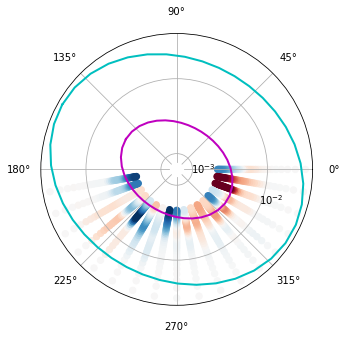

In [23]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    # # There should be a method for this, but there isn't... Pull request?
    # ax2._r_label_position._t = (22.5 + 180, 0.0)
    # ax2._r_label_position.invalidate()
    # # Ensure that original axes tick labels are on top of plots in twinned axes
    # for label in ax.get_yticklabels():
    #     ax.figure.texts.append(label)
    return ax2


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='polar')
ax2 = polar_twin(ax)
for i in range(len(piw.angle)):
    # y = piw.scale**-1*1e3 * np.sin(piw.angle.isel(angle=i))
    # x = piw.scale**-1*1e3 * np.cos(piw.angle.isel(angle=i))
    # ax.scatter(x, y, c=piw.isel(Z=1,angle=i).mean('nmemb')*1e8, 
    #            cmap='RdBu_r', vmax=.008, vmin=-.008, s=20)
    im = ax.scatter(-Fmte.angle.isel(angle=i).values*np.ones_like(Fmte.scale), Fmte.scale**-1*1e3, 
                    c=Fmte.isel(Z=1,angle=i).mean('nmemb')*1e9, 
                    cmap='RdBu_r', vmax=values[reg], vmin=-values[reg], s=40)

# ax.plot(xx.isel(reg=0)[0]/a.isel(Z=0).sel(XC=xs[0], YC=ys[0], method='nearest'), 
#         xx.isel(reg=0)[1]/a.isel(Z=0).sel(XC=xs[0], YC=ys[0], method='nearest'), 
#         'k', alpha=.7)

ax2.plot(angles+dskl.theta.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values, 
         (r/a).isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values*piw.scale[0].values**-1*1e3, 
         'c', lw=2)
ax2.plot(angles+dskl.theta_250km.isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values, 
         (r25/a25).isel(Z=1).sel(XC=xs[reg],YC=ys[reg],method='nearest').values*piw.scale[0].values**-1*1e3*.45, 
         'm', lw=2)

ax.set_rticks([1e-3, 1e-2]) 
ax.set_rlabel_position(-24.5) 
ax.set_rlim(9e-4, piw.scale[0]**-1*1e3)
ax.set_rscale('symlog', linthresh=1e-3)
ax.grid(True)
ax2.grid(False)
ax2.set_yticklabels([])
# cbar = fig.colorbar(im, ax=ax, shrink=.7)
# cbar.set_label(r"$\tilde{\epsilon}_K$ ($\times 10^{-8}$) [m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figs/Polar_MtE_region%02d_Z452.pdf' % reg))
# plt.savefig(op.join(savedir,'Figs/Polar_MtE_reenvisioned_region%02d_Z452.pdf' % reg))